
### Before you start this notbook. 
Create a .env files in same place you have placed this notebook and add following two keys. You can get the API keys from respective website.  
OPENAI_API_KEY=<<key>>   
FIRECRAWL_API_KEY=<<key>>  

In [ ]:
from dotenv import load_dotenv, dotenv_values
import certifi
import ssl
import os
import json

ssl_context = ssl.create_default_context(cafile=certifi.where())
os.environ["SSL_CERT_FILE"] = certifi.where()

_ = load_dotenv()

from openai import OpenAI

In [2]:
from langgraph.graph import StateGraph, END, START
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from langchain_core import tools
from langchain_community.document_loaders.firecrawl import FireCrawlLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

from firecrawl import FirecrawlApp
import requests
from bs4 import BeautifulSoup, Comment

from langchain_core.documents import Document

from langchain_openai import OpenAIEmbeddings
# pip install -qU langchain-chroma
from langchain_chroma import Chroma

# Crawling website data

In [3]:
list_of_urls_to_crawl= [
    "https://www.americanfreight.com/pdp/hershey-navy-sectional-2-piece-set/392866?uid=67155038&w=al-p-il",
    "https://www.americanfreight.com/pdp/groovy-navy-2-piece-sectional/363175?uid=67155064&w=al-p-il",
    "https://www.americanfreight.com/pdp/gretna-grey-2-piece-sectional/389997?uid=67155016&w=al-p-il",
    "https://www.americanfreight.com/pdp/haven-chocolate-sectional/392918?uid=67155067&w=al-p-il",
    "https://www.americanfreight.com/pdp/zoey-indigo-loveseat/389272?uid=67155027&w=al-p-il",
    "https://www.americanfreight.com/pdp/hershey-pebble-loveseat/392795?uid=67155036&w=al-p-il",
    "https://www.americanfreight.com/pdp/archer-pewter-loveseat/392748?uid=67154997&w=al-p-il",
    "https://www.americanfreight.com/pdp/fletcher-ottoman/391648?uid=67155046&w=al-p-il",
    "https://www.americanfreight.com/pdp/tide-cloud-storage-ottoman/359839?uid=67155039&w=al-p-il",
    "https://www.americanfreight.com/pdp/gretna-grey-ottoman/390531?uid=67155015&w=al-p-il"
]

In [4]:
def get_description_and_specfication(url: str) -> dict:
    try:
        response_website = requests.get(url)

        response_website_str = response_website.content.decode('utf-8')
        soup = BeautifulSoup(response_website_str, 'html.parser')
        for comment in soup.find_all(string=lambda text: isinstance(text, Comment)):
            comment.extract()        
        overview = soup.find("div", id="pdp--overview-content")
        specification = soup.find('div', id="specs--show-more-container")

        return {"page_content": f' "Overview" + {overview.getText()} \n url {url} \n\n\n "Specification" {specification.getText()}', "metadata":{"url": url}}
    except Exception as e:
        print(f"Exception: {e}")

In [5]:
def get_description_and_specfication_firecrawl(url: str) -> str:
    url = "https://api.firecrawl.dev/v1/scrape"
    headers = {
        "Content-Type": "application/json",
        "Authorization": f'Bearer {os.getenv("FIRECRAWL_API_KEY")}'
    }
    payload = {
        "url": url,
        "formats": ["json"],
        "jsonOptions": {
            "prompt": "Extract Item overview and specification"
        }
    }
    response = requests.post(url, headers=headers, json=payload)
    response_json = response.json()
    return response_json['data']['json']['itemOverview'] + "\n\n" + get_specification_in_str_frmt(response_json['data']['json']['specifications'])

def get_specification_in_str_frmt(specs: list[dict]):
    specs_str = ''
    if len(specs):
        for each_dict in specs:
            specs_str += f'{each_dict["specificationName"]}: {each_dict["specificationValue"]} \n'
        return specs_str

In [6]:
# get_description_and_specfication_firecrawl("https://www.americanfreight.com/pdp/gretna-grey-ottoman/390531?uid=67155015&w=al-p-il")

In [7]:
# dict_list = [{'specificationName': 'ASSEMBLY REQUIRED', 'specificationValue': 'YES'}, {'specificationName': 'COLOR FAMILY', 'specificationValue': 'Blue'}, {'specificationName': 'CUSTOM DIMENSIONS', 'specificationValue': "76''W X 34''D X 36''H"}, {'specificationName': 'INCLUDES', 'specificationValue': 'Sofa'}, {'specificationName': 'MATERIAL', 'specificationValue': 'Polyester'}, {'specificationName': 'PIECE', 'specificationValue': 'Sofa'}, {'specificationName': 'STYLE', 'specificationValue': 'Casual'}, {'specificationName': 'WARRANTY', 'specificationValue': '1 Year Manufacturers Limited Warranty'}]

### Testing get_description_and_specfication

In [8]:
get_description_and_specfication("https://www.americanfreight.com/pdp/gretna-grey-ottoman/390531?uid=67155015&w=al-p-il")

{'page_content': ' "Overview" + Kick your feet up and unwind with the Gretna Grey Ottoman. This vibrant, cozy ottoman allows you a place to stretch your legs and offers additional seating for guests. Made with a CertiPur foam seat core, it offers exceptional comfort. Take home this ottoman today and pair it with the matching sofa and loveseat set for a complete look.\n Certipur foam seat cores\n Contains Wood Products certified by the Sustainable Forest Initiative \n  Price Includes: 1 Ottoman \n url https://www.americanfreight.com/pdp/gretna-grey-ottoman/390531?uid=67155015&w=al-p-il \n\n\n "Specification" SpecificationsASSEMBLY REQUIRED\xa0\xa0\xa0YESCOLOR FAMILY\xa0\xa0\xa0GreyCUSTOM DIMENSIONS\xa0\xa0\xa041\'\'W  X  25\'\'D  X  21\'\'HFINISH\xa0\xa0\xa0PewterINCLUDES\xa0\xa0\xa0OttomanMATERIAL\xa0\xa0\xa0PolyesterPIECE\xa0\xa0\xa0OttomanSTYLE\xa0\xa0\xa0Modern/ContemporaryWARRANTY\xa0\xa0\xa01 Year Manufacturers Limited Warranty',
 'metadata': {'url': 'https://www.americanfreight.c

# Vector store

## Creating langchain sepcific document object

In [9]:
all_docs = []

for url in list_of_urls_to_crawl:
    details = get_description_and_specfication(url)
    if details:
        document = Document(
            page_content=details["page_content"],
            metadata=details["metadata"]
        )
        all_docs.append(document)

In [10]:
len(all_docs)

10

In [80]:
all_docs[0]

Document(metadata={'url': 'https://www.americanfreight.com/pdp/hershey-navy-sectional-2-piece-set/392866?uid=67155038&w=al-p-il'}, page_content=' "Overview" + Embrace the comfort of the Hershey Navy 2-Piece Sectional. It\'s beautiful navy cover fabric, complemented by accent pillows, effortlessly suits various styles & is made of durable polyester cloth. \nAccent pillows included (2)\nPrice Includes: Complete Sectional \n url https://www.americanfreight.com/pdp/hershey-navy-sectional-2-piece-set/392866?uid=67155038&w=al-p-il \n\n\n "Specification" SpecificationsASSEMBLY REQUIRED\xa0\xa0\xa0YESCOLLECTIONS\xa0\xa0\xa02pc. CollectionCOLOR FAMILY\xa0\xa0\xa0BlueCUSTOM DIMENSIONS\xa0\xa0\xa0108\'\'W X 77\'\'D X 39\'\'HINCLUDES\xa0\xa0\xa01 SectionalMATERIAL\xa0\xa0\xa0PolyesterSTYLE\xa0\xa0\xa0CasualWARRANTY\xa0\xa0\xa01 Year Manufacturers Limited Warranty')

# Creating Embeddings using OpenAI

In [12]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    collection_name="site_search",
    embedding_function=embeddings,
    persist_directory="./chroma_searcj_langchain_db",  # Where to save data locally, remove if not necessary
)

In [13]:
ids = vector_store.add_documents(documents=all_docs)

In [14]:
ids

['81df7741-6d06-40da-a3cc-f4f6d7850c6f',
 '1d05b1b5-c35a-4766-ae3e-4f8d468cb677',
 '20f01c69-f3c4-4bf4-984d-28a78501a880',
 '24af3a17-fbf7-4b63-9397-44057f90858a',
 'bf4ff369-1216-4597-9bdb-0f1fba921d56',
 'bbd87ebf-dc79-4053-8c77-acd5129c93ab',
 '34447cb6-8dd2-4899-9f44-ed9810330303',
 '7f9d4fba-a0c2-4e71-9d9a-462416a9bdef',
 '3868beec-25be-4c99-aaec-79041114e613',
 'f6f70699-cbb1-460f-a1d1-af8991aa077b']

### Testing Semantic Search

In [15]:
results = vector_store.similarity_search(
    "blue living room")

In [17]:
type(results)

list

In [18]:
results[0]

Document(id='c2f3ab02-2b7f-467c-9897-6de73d237d08', metadata={'url': 'https://www.americanfreight.com/pdp/zoey-indigo-loveseat/389272?uid=67155027&w=al-p-il'}, page_content="OverviewInfuse your living space with a captivating burst of flair and color with the Zoey Indigo Loveseat. Its striking indigo polyester upholstery brings a burst of color and charm. Sink into the softness of the plush pillows, ensuring optimal support for your movie nights and moments of relaxation. The loveseat's track arms and tapered legs exude a modern and sleek vibe. Complete the ensemble with the included contrasting accent pillows, adding a touch of style. Take home the Zoey Indigo Sofa to complete the ensemble. Embrace both style and comfort by making this loveseat yours today!\n Accent pillows included\n Track arms\n Contemporary casual\n  Price Includes: 1 Loveseat\n\n\nSpecificationSpecificationsASSEMBLY REQUIRED\xa0\xa0\xa0YESCOLOR FAMILY\xa0\xa0\xa0BlueCUSTOM DIMENSIONS\xa0\xa0\xa054''W  X  34''D  X 

# Multi-Agent creation

In [19]:
MODEL = 'gpt-4o'
model = ChatOpenAI(model=MODEL)

from langchain_core.prompts import ChatPromptTemplate
from typing import TypedDict

In [20]:
prompt_final = '''
You are smart home decorator and designer. You will be provided with secarios to build a room or whole hours and you are required to use the square feet 
if given and use the dimension of the furniture to design the house. You can use all different decoration or design patterns like
mid-century modery, Rustic, framhouse, scandinavian, minimalism, art deco. You will be proivded with description and sepcification of the furniture items
and you decide each piece of furniture to match the what cusomter is asking and also provid additional suggestion apart from what customer asked.

Question: {question}
Context: {context}
Answer:

Here is an example of the input:
Question: I would like to design a living room with blue shades and rustic look with a sq of 200
Context: [Document(page_content="soft sofa with blue that can sit 4 and its specification CUSTOM DIMENSIONS | 76''W X 34''D X 36''H ",
    metadata={{"url":"https://urls.com"}}),
    Document(page_content="soft blue ottoman  specification CUSTOM DIMENSIONS | 76''W X 34''D X 36''H ",
    metadata={{"url":"https://urls.com"}})
    ]

Here is an example of the Output:
Recommendation: You can use following soft sofat in blue in combination with Ottoman that is a blue shade to make the room look rustic. Soft sofa is of
following dimenions XXX and ottoman is of the following dimension XXX and should easily fit the squre feet provided. Below are the suggested items for you room look.
Total space: Calculate the total space needed from dimension
Urls: 1. Sofa - url 2. Ottoman - url
'''.strip()

In [78]:
prompt_vector_searh_string = '''
You are a smart interior decoratoer who can pull common words that are useful for building colors and furniture based on the sentence provided.
You will return all the key words required to build a semantic search query so related items can be provided based on the response you provide later.
Apart from the keyword you can include other colors that complement them so a proper semantic search with all the items can be queried

Question: {question}

Example:
Question: I would like to design a living room with blue shades and rustic look with a sq of 200
Response:  Living room blue shades rustic square feet 200

'''.strip()

In [54]:
prompt_template_vector_search_string = ChatPromptTemplate([
    ("system", prompt_vector_searh_string),
 
])

In [55]:
prompt_template = ChatPromptTemplate([
    ("system", prompt_final),
 
])

In [56]:
from typing import List
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
    semantic_search_text: str

In [81]:
def vector_search(state: State):
    ''' Chroma vector search'''
    print(f"Semantic search text used: {state['semantic_search_text']}")
    retrieve_docs = vector_store.similarity_search(state["semantic_search_text"])
    return {"context":retrieve_docs}

def llm_final_results(state: State):
    doc_content = "\n\n".join(doc.page_content for doc in state["context"])

    message = prompt_template.invoke({"question":state["question"], "context":doc_content})
    response = model.invoke(message)
    return {"answer": response.content}

def llm_semantic_search_string(state: State):
    message = prompt_template_vector_search_string.invoke({"question":state["question"]})
    response = model.invoke(message)
    print(response.content)
    return {"semantic_search_text": response.content}

In [82]:
graph_builder = StateGraph(State).add_sequence([llm_semantic_search_string, vector_search, llm_final_results])
graph_builder.add_edge(START, "llm_semantic_search_string")
graph = graph_builder.compile()

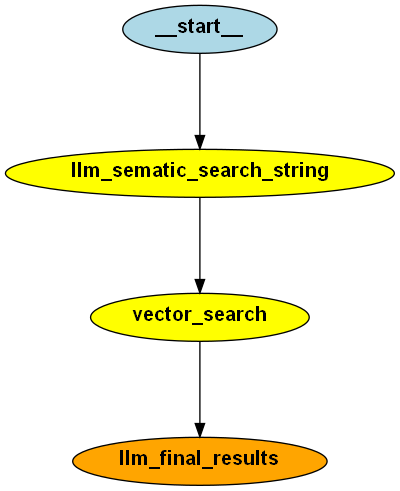

In [83]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [74]:
response = graph.invoke({"question": "I am looking for living room furniture of square feet 200 to build with all blues"})


Living room furniture blue square feet 200
Sematic search text used: Living room furniture blue square feet 200


In [77]:
print(response["answer"])

Recommendation:

For a 200-square-foot living room decked out in shades of blue, I recommend focusing on creating a harmonious and cohesive look while ensuring the furniture fits perfectly within the given space. Here's a curated selection of furniture options based on your requirements:

1. **Groovy Navy 2-Piece Sectional with Chaise**
   - Dimensions: 124''W  X  40''D  X  41''H
   - Total Width: 124 inches
   - Features: Navy microfiber-polyester upholstery, rolled arms, chaise lounge, and stylish tapered block-style feet.
   - Style: Glam with a sleek and modern aesthetic.

   The sectional will provide ample seating for lounging and accommodates guests comfortably. The deep navy hue aligns with the blue theme, and the accent pillows add a touch of style.

2. **Zoey Indigo Loveseat**
   - Dimensions: 54''W  X  34''D  X  36''H
   - Total Width: 54 inches
   - Features: Indigo polyester upholstery with track arms and tapered legs.
   - Style: Contemporary casual with a burst of color 